# CS445: Term Project

#### Victor Weeks & Josh Lutz

Note: I think I am going to explore changing my idea to taking current inventory info and deciding how best to make a profit

## Introduction

In [2]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [3]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [5]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(10659, 13)

In [6]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [26]:
def makeItemData(itemID=19718, allItems=False, splitData=False, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    if allItems:
        itemData = np.mean(itemTimeData[0:50], axis=0).reshape((1,-1))
        for bucket in itemTimeData[51::51]:
            itemData = np.vstack((itemData, np.mean(bucket.reshape((1,-1)), axis=0).reshape((1,-1))))
    else:
        itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, 1:7].copy()
    T = itemData[stepsAheadToPredict:, 1:2].copy()
    if splitData:
        rows = np.arange(X.shape[0])
        nTrain = int(X.shape[0] * 0.7)
        Xtrain = X[rows[:nTrain],:]
        Ttrain = T[rows[:nTrain],:]
        Xtest = X[rows[nTrain:],:]
        Ttest = T[rows[nTrain:],:]
        return Xtrain, Ttrain, Xtest, Ttest
    else:        
        return X, T, itemData

Note: Had to make sure to copy the X and T data because of how the Time-Embedded data is accessed.

In [30]:
XtrainAll, TtrainAll, items = makeItemData(allItems=True) # training with all items
Xtest1, Ttest1, item1 = makeItemData(19735)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((198, 6), (198, 1), (198, 6), (198, 1))

In [9]:
XtrainA, TtrainA, XtestA, TtestA = makeItemData(19743, allItems=True, splitData=True) #Train and test with all items
XtrainA.shape, TtrainA.shape, XtestA.shape, TtestA.shape

((143, 6), (143, 1), (62, 6), (62, 1))

In [41]:
Xtrain, Ttrain, Xtest, Ttest = makeItemData(19718, splitData=True) #Train and test with all items
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((145, 6), (145, 1), (63, 6), (63, 1))

In [10]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [28]:
import pandas as pd
def getBestAvgNeuralStructure(Xtrain,Xtest,Ttrain,Ttest,nIterations=1000,timesToAvg=5,plot=False):
    errors = []
    hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
    for hids in hiddens:
        errorTrain = 0
        errorTest = 0
        errorAvg = 0
        for _ in range(timesToAvg):
            nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
            nnet.train(Xtrain, Ttrain, nIterations)
            errorTrain += rmse(Ttrain, nnet.use(Xtrain))
            errorTest += rmse(Ttest, nnet.use(Xtest))
            errorAvg = (errorTrain + errorTest)/2
        errors.append([hids,errorTrain/timesToAvg,errorTest/timesToAvg,errorAvg/timesToAvg])
    errors = pd.DataFrame(errors)
    print(errors)
    if plot==True:
        plt.figure(figsize=(10, 10))
        plt.plot(errors.values[:, 1:], 'o-')
        plt.title('RMSE Values for Neural Net')
        plt.legend(('Train', 'Test', 'Avg Error'))
        plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
        plt.grid(True)
    minErrorAverage = errors[3].min()
    minIndex = list(errors[3]).index(minErrorAverage)
    bestHids = errors[0][minIndex]
    print('Lowest average error over',timesToAvg,'fully trained iterations:',bestHids,'with error:',minErrorAverage)
    return bestHids

4.10777984008e-21
1.607122563e-17
1.54668026165e-21
1.87073296164e-21
1.6886048705e-21
1.70716175951e-17
7.07048775785e-17
6.08138941673e-17
1.6255643139e-16
6.17296501102e-17
                       0         1         2         3
0                      0  0.740510  1.278410  1.009460
1                    [1]  0.671472  2.799579  1.735526
2                 [1, 1]  0.671855  2.796802  1.734328
3              [1, 1, 1]  0.671987  2.794562  1.733275
4           [1, 1, 1, 1]  0.672010  2.793332  1.732671
5        [1, 1, 1, 1, 1]  0.671938  2.790680  1.731309
6                    [5]  0.356866  3.692238  2.024552
7                 [5, 5]  0.307590  3.771618  2.039604
8              [5, 5, 5]  0.293639  3.574828  1.934234
9           [5, 5, 5, 5]  0.329923  4.021754  2.175839
10       [5, 5, 5, 5, 5]  0.353897  5.811819  3.082858
11                  [10]  0.306249  3.750251  2.028250
12              [10, 10]  0.293850  3.759345  2.026598
13          [10, 10, 10]  0.293451  4.048579  2.171015

0

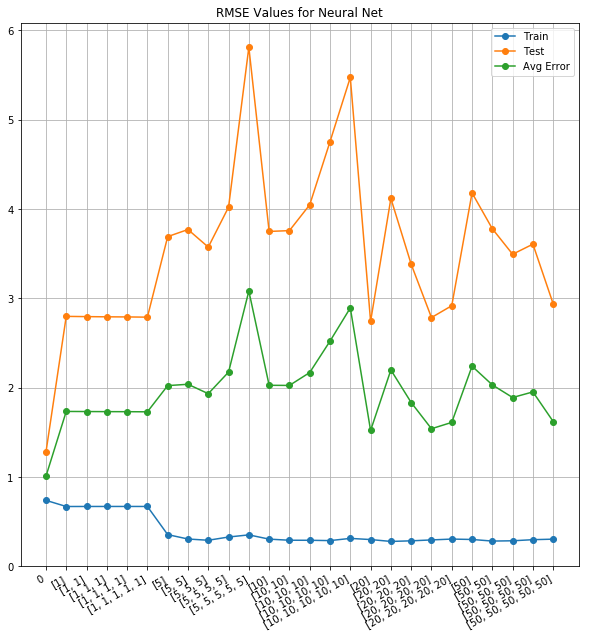

In [34]:
getBestAvgNeuralStructure(Xtrain,Xtest,Ttrain,Ttest,1000,5,True)

In [ ]:
getBestAvgNeuralStructure(Xtrain,Xtest,Ttrain,Ttest,1000,5,True)

#### Time-Embedding

In [30]:
def rollingWindows(X, windowSize):    
    nSamples, nAttributes = X.shape
    nWindows = nSamples - windowSize + 1
    # Shape of resulting matrix
    newShape = (nWindows, nAttributes * windowSize)
    itemSize = X.itemsize  # number of bytes
    # Number of bytes to increment to starting element in each dimension
    strides = (nAttributes * itemSize, itemSize)
    return np.lib.stride_tricks.as_strided(X, shape=newShape, strides=strides)

In [14]:
Xtrain[0:2]

array([[  3.18580000e+02,   3.58220000e+02,   5.57863420e+05,
          1.63556236e+06,   0.00000000e+00,   0.00000000e+00],
       [  7.70000000e+01,   9.20000000e+01,   6.64614000e+05,
          4.51649000e+05,   0.00000000e+00,   0.00000000e+00]])

In [15]:
XtrainW[0]

array([  3.18580000e+02,   3.58220000e+02,   5.57863420e+05,
         1.63556236e+06,   0.00000000e+00,   0.00000000e+00,
         7.70000000e+01,   9.20000000e+01,   6.64614000e+05,
         4.51649000e+05,   0.00000000e+00,   0.00000000e+00])

In [16]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10,10], Ttrain.shape[1])
nnet.train(Xtrain, Ttrain, 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.257318363333 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.223812384722 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.176662433645 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.156707204184 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.154519192839 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.152376183021 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.15033338351 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.147998688858 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.144842837622 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.140550498069 Scale 1e-15


NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1886 seconds. Final error is 0.37490065093186237.

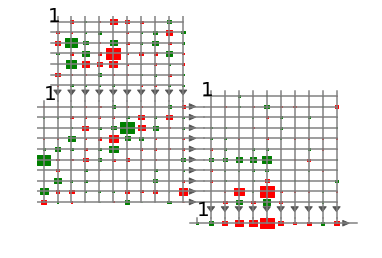

In [17]:
nnet.draw()

NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1886 seconds. Final error is 0.37490065093186237.


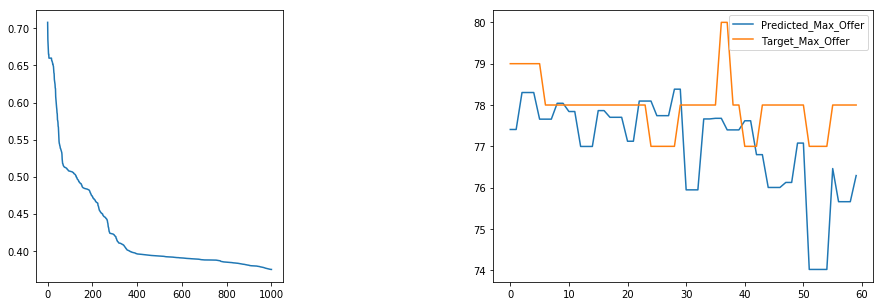

In [18]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(Xtest)
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted_Max_Offer')
plt.plot(Ttest, label='Target_Max_Offer')
plt.legend();

In [42]:
XtrainW = rollingWindows(Xtrain, 2)
TtrainW = rollingWindows(Ttrain, 2)
XtestW = rollingWindows(Xtest, 2)
TtestW = rollingWindows(Ttest, 2)
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((144, 12), (144, 2), (62, 12), (62, 2))

In [43]:
keepTrain = [ len(np.unique(Trow))==1 for Trow in TtrainW ]
keepTest = [ len(np.unique(Trow))==1 for Trow in TtestW ]
sum(keepTrain)

122

In [44]:
XtrainW = XtrainW[keepTrain, :]
TtrainW = TtrainW[keepTrain, :]
TtrainW = TtrainW[:, 0:1] # reduce to single class label

XtestW = XtestW[keepTest, :]
TtestW = TtestW[keepTest, :]
TtestW = TtestW[:, 0:1] # reduce to single class label

1.17902172337e-16
8.34322898313e-17
5.602512977e-17
9.78589507592e-17
2.01981073567e-16
1.75414890366e-16
3.04349062435e-17
1.37638508731e-16
1.67105020643e-16
1.38142938605e-16
                       0         1         2         3
0                      0  1.206105  0.999364  1.102735
1                    [1]  1.160005  1.105574  1.132790
2                 [1, 1]  1.160355  1.106437  1.133396
3              [1, 1, 1]  1.188611  1.085980  1.137296
4           [1, 1, 1, 1]  1.181018  1.124661  1.152839
5        [1, 1, 1, 1, 1]  1.247257  1.074364  1.160810
6                    [5]  0.314360  3.501735  1.908047
7                 [5, 5]  0.197900  3.486704  1.842302
8              [5, 5, 5]  0.197180  1.696392  0.946786
9           [5, 5, 5, 5]  0.165784  1.692172  0.928978
10       [5, 5, 5, 5, 5]  0.281044  2.153988  1.217516
11                  [10]  0.116946  7.461922  3.789434
12              [10, 10]  0.052207  3.753743  1.902975
13          [10, 10, 10]  0.055217  3.143870  1.5995

[5, 5, 5, 5]

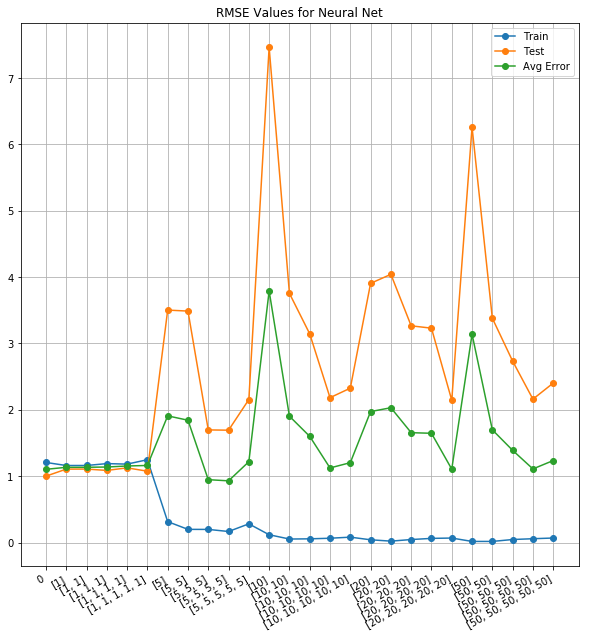

In [45]:
getBestAvgNeuralStructure(XtrainW,XtestW,TtrainW,TtestW,1000,5,True)

In [21]:
nnet = nn.NeuralNetwork(XtrainW.shape[1], [10,10,10], TtrainW.shape[1])
nnet.train(XtrainW/(XtrainW.max(axis=0)), TtrainW/(TtrainW.max(axis=0)), 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.0689566428167 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.0337889637952 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.0259649331972 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.0219462078174 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.0108556535825 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.00350756001693 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.00221208157337 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.00174119483695 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.00119739510318 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.000994592085493 Scale 1e-15


NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1720 seconds. Final error is 0.03153715404871833.

NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.1720 seconds. Final error is 0.03153715404871833.


C:\Users\Pooka\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Pooka\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


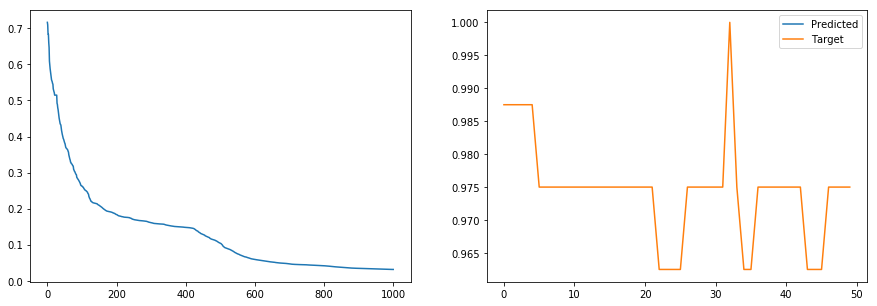

In [22]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(XtestW/(XtestW.max(axis=0)))
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted')
plt.plot(TtestW/(TtestW.max(axis=0)), label='Target')
plt.legend();

## Methods

Notes: 
* could seperate all items into train and test data
* could train on one item, test on another

In [ ]:
# This method acts as the reinforcement and accounts for the 15% handling cost for selling items on the market
def checkForProfit(price_sold, price_bought):
    profit = (price_sold - (price_sold * 0.15)) - price_bought
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0

## Results

## Conclusions

## References